In [ ]:
# I usually put all libraries I use on top of the Notebook
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from binance.client import Client
import datetime as dt
from pytz import timezone
from scipy.stats import zscore
import seaborn as sns
from statsmodels.tsa.stattools import coint

In [ ]:
# Task 1. Data Retrieval

# Objective: Retrieve historical data using the API of a crypto exchange, such as Kraken or Binance. Requirements:
# • Select either BTCUSD or ETHUSD on Kraken, or BTCUSDT or ETHUSD on Binance as the trading pair. ☑️
# • Retrieve at least 30 days of 1-minute interval data for OHLC (Open, High, Low, Close) prices and trading volume. ☑️
# • Provide code that demonstrates the data retrieval process via the API. ☑️

#---------------------------------------------------------------------------------------------------------------------------------

api_key = 'hbJL4wO7LeYX6FkKuVW08PpoBgiOUOwdUYAhYLSG40xzpaywcEPgRjPgGBXGyS3B'
api_secret = 'qHm85rDfxljX5FhvjoAVEPbQ119Teu78SAw9KERQ3YtLD8mMHH2NRVUNef9Tb2zX'

client = Client(api_key, api_secret)


def get_historical_klines(symbol, interval, start_str, end_str=None):
    
    # Fetch historical klines from Binance.

    # param symbol: str e.g., 'BTCUSDT'
    # param interval: str e.g., Client.KLINE_INTERVAL_1HOUR
    # param start_str: str e.g., '7 Nov, 2024'
    # param end_str: str e.g., '6 Dec, 2024' (optional)
    # possible columns:  'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades','taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    # return: pd.DataFrame
   
    klines = client.get_historical_klines(symbol, interval, start_str, end_str)
    df = pd.DataFrame(klines, columns=[
        'open_time', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('open_time', inplace=True)
    # Keep only the Open, High, Low, Close columns and convert them to float
    df = df[['open', 'high', 'low', 'close']].astype(float)
    return df


#---------------------------------------------------------------------------------------------------------------------------------

# Choose the following parameters and run the program:

symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1MINUTE  # 1-minute intervals
start_date = '7 Nov, 2024'
end_date = '6 Dec, 2024'

df = get_historical_klines(symbol, interval, start_date, end_date)

# Save the dataframe in a csv format:

file_name = "Binance_BTCUSDT_30Days_1Min.csv" 
df.to_csv(file_name)


In [ ]:
# Task 2. Data Cleaning 1/4 - General Inspection of the datasets

# Objective: Preprocess the raw data to make it suitable for analysis. Requirements:
# • Handle any missing timestamps or NaN values. ☑️
# • Remove duplicate rows, if any. ☑️
# • Convert timestamps to the CET timezone. ☑️


# Comment from Tim: 
# As my csv file from Task 1 already contains an ISO time, 
# I will use Matteo's csv files to demonstrate how I translate the time format from UNIX timestamp to ISO time.

#The following program runs through basic checks to assess the state of the dataset.
#---------------------------------------------------------------------------------------------------------------------------------

def process_and_validate_file(filename):


    # Load the dataset
    data = pd.read_csv(filename)
    
    # Convert the 'time' column to a datetime object in UTC and then to CET
    data['time'] = pd.to_datetime(data['time'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/Berlin')
    
    # Check for missing timestamps
    time_diff = data['time'].diff().value_counts()
    print(f"Timestamp Intervals in {filename}:")
    print(time_diff)
    
    if time_diff.shape[0] == 1 and time_diff.index[0] == pd.Timedelta(minutes=1):
        print("\nTimestamps are consistent (1-minute intervals). ✔️")
    else:
        print("\nTimestamps are not consistent. Please investigate further. ❌")
    
    # Check for missing values (NaN) in the dataset
    missing_values = data.isna().sum()
    print(f"\nMissing Values in {filename}:")
    print(missing_values)
    
    if missing_values.sum() == 0:
        print("No missing values in the dataset. ✔️")
    else:
        print("There are missing values in the dataset. Please address them. ❌")
    
    # Check for duplicate rows
    duplicate_count = data.duplicated().sum()
    print(f"\nNumber of duplicate rows in {filename}: {duplicate_count}")
    
    if duplicate_count > 0:
        print("Duplicate rows found. Consider removing them for a clean dataset. ❌")
    else:
        print("No duplicate rows found. ✔️")
    
    # Optional: Drop duplicates (uncomment if needed)
    # data = data.drop_duplicates()
    
    return data

#---------------------------------------------------------------------------------------------------------------------------------

# Enter file name and run the program:
filename = 'Interpolated Datasets/KRAKEN_ETHUSD_interpolated.csv'  
processed_data = process_and_validate_file(filename)

# Save the processed data to a new file
# output_filename = "KRAKEN_ETHUSD_CLEANED.csv"
# processed_data.to_csv(output_filename, index=False)
# print(f"Cleaned dataset saved as {output_filename}.")

# Comment from Tim: 
# If there should be missing timestamps or NaN values, one would need to discuss whether to entirely drop these rows (just like the duplicates),
# or whether to fill them with a value, such as: Forward-fill, Backward-fill, linear interpolation, etc. It depends on the goal of the data analysis.
# Examples for handling irregularities:
    # Forward-fill: data.fillna(method='ffill', inplace=True)
    # Backward-fill: data.fillna(method='bfill', inplace=True)
    # Fill with specific value (e.g., 0): data.fillna(0, inplace=True)
    # Drop Rows: data.dropna(inplace=True)
    # Linear Interpolation: data.interpolate(method='linear', inplace=True)


Timestamp Intervals in Interpolated Datasets/KRAKEN_ETHUSD_interpolated.csv:
time
0 days 00:01:00    3384
Name: count, dtype: int64

Timestamps are consistent (1-minute intervals). ✔️

Missing Values in Interpolated Datasets/KRAKEN_ETHUSD_interpolated.csv:
time      0
open      0
high      0
low       0
close     0
Volume    0
dtype: int64
No missing values in the dataset. ✔️

Number of duplicate rows in Interpolated Datasets/KRAKEN_ETHUSD_interpolated.csv: 0
No duplicate rows found. ✔️


In [32]:
# 2. Data Cleaning 2/4 - Clean the Kraken dataset. Interpolate missing timestamps.

# Load your dataset
file_path = 'Matteos Datasets/KRAKEN_ETHUSD.csv'  # Adjust the path as needed
eth_data = pd.read_csv(file_path)

# Ensure the 'time' column is numeric
eth_data['time'] = pd.to_numeric(eth_data['time'], errors='coerce')

# Set the time column as the index and create a complete time range
eth_data.set_index('time', inplace=True)
complete_time_index = pd.RangeIndex(start=eth_data.index.min(), stop=eth_data.index.max() + 60, step=60)

# Reindex the dataframe to include all timestamps
eth_data = eth_data.reindex(complete_time_index)

# Reset index back to the 'time' column
eth_data.reset_index(inplace=True)
eth_data.rename(columns={'index': 'time'}, inplace=True)

# Perform linear interpolation for missing values
eth_data.interpolate(method='linear', inplace=True)

# Save the corrected dataset (optional)
eth_data.to_csv('KRAKEN_ETHUSD_interpolated.csv', index=False)

print("Missing rows have been interpolated. The dataset now has 1-minute intervals.")

Missing rows have been interpolated. The dataset now has 1-minute intervals.


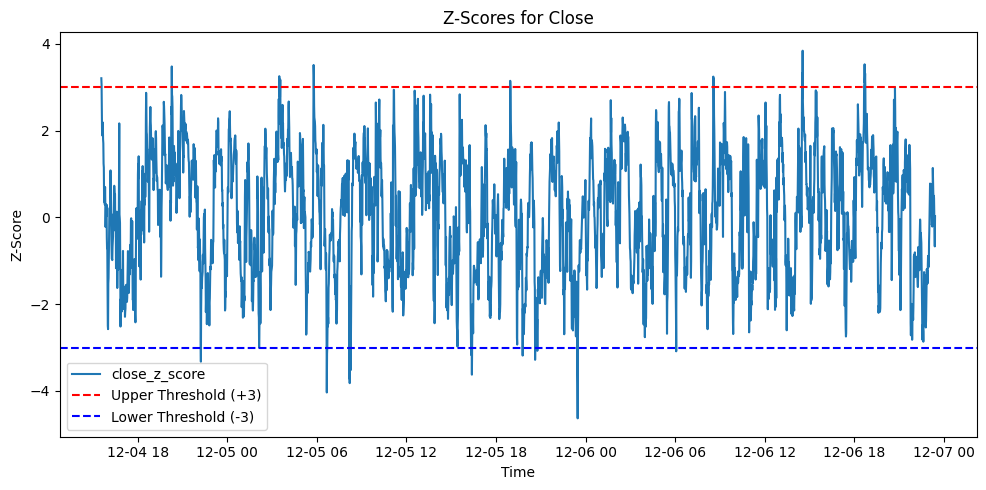

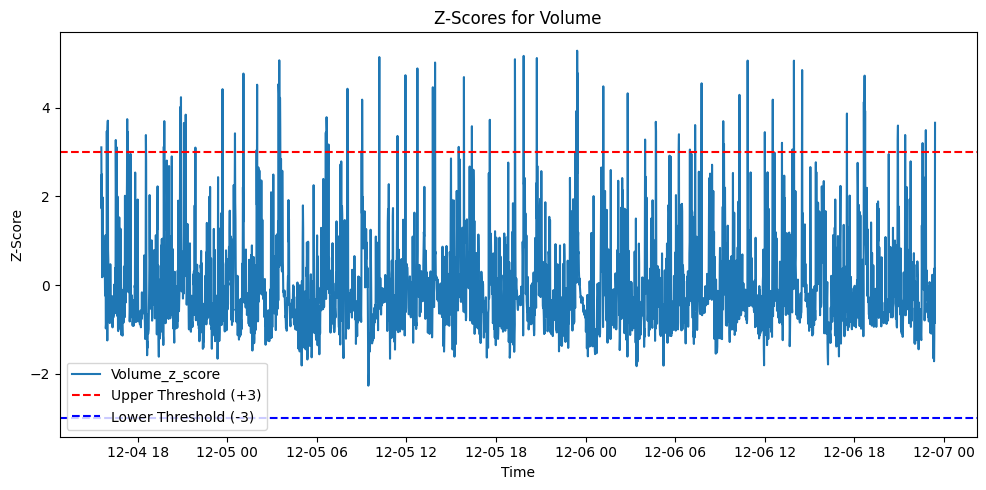

In [ ]:
# 2. Data Cleaning 3/4
# • Address outliers in price or volume (explain your approach). ☑️

# Comment from Tim: 
# I will use a rolling Z-Score to identify outliers.
# The rolling window is 30min.
# Datapoints with Z-Score beyond ±3 I will consider as an outlier.
# As an example, I will demonstrate my approach with the "BINANCE_BTCUSDT_CLEANED.csv" dataset.
# I will visualize my idea with plots for each feature.
# However, my approach is somewhat arbitrary. I would need to study this topic in more detail to figure out what the best
# method would be to find outliers in trading data.

#---------------------------------------------------------------------------------------------------------------------------------


file_name = 'Cleaned Datasets/BINANCE_BTCUSDT_CLEANED.csv' # Adjust the path as needed
data = pd.read_csv(file_name)

# Ensure 'time' is treated as a datetime object
data['time'] = pd.to_datetime(data['time'])

# Set 'time' as the index to handle rolling operations easily
data.set_index('time', inplace=True)

# Function to calculate rolling Z-Score
def rolling_z_score(series, window_size):
    rolling_mean = series.rolling(window=window_size).mean()
    rolling_std = series.rolling(window=window_size).std()
    z_score = (series - rolling_mean) / rolling_std
    return z_score

# Define the rolling window in minutes (30 minutes for a 1-minute interval dataset)
window_size = 30

# Apply the rolling Z-Score and detect outliers for each relevant column
columns_to_check = ['open', 'high', 'low', 'close', 'Volume']
for column in columns_to_check:
    z_score_column = f"{column}_z_score"
    outlier_column = f"{column}_outlier"
    
    # Calculate rolling Z-Score
    data[z_score_column] = rolling_z_score(data[column], window_size)
    
    # Identify outliers based on Z-Score threshold
    data[outlier_column] = (data[z_score_column].abs() > 3)

# Save the dataset with the new outlier columns to the current directory
#output_file_name = file_name.replace("CLEANED", "OUTLIERS")
#data.to_csv(output_file_name)

columns_to_plot = ['close_z_score', 'Volume_z_score']

for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column], label=column)
    plt.axhline(3, color='red', linestyle='--', label='Upper Threshold (+3)')
    plt.axhline(-3, color='blue', linestyle='--', label='Lower Threshold (-3)')
    plt.title(f"Z-Scores for {column.replace('_z_score', '').capitalize()}")
    plt.xlabel('Time')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.tight_layout()
    plt.show()





In [ ]:
# 2. Data Cleaning 4/4
# • Aggregate the data into hourly intervals while maintaining the OHLC structure. ☑️

file_path = "Cleaned Datasets/BINANCE_BTCUSDT_CLEANED.csv" # Adjust the path as needed
data = pd.read_csv(file_path)

# Ensure the timestamp column is in datetime format
data['time'] = pd.to_datetime(data['time'])

# Set the timestamp column as the DataFrame index
data.set_index('time', inplace=True)

# Resample to hourly frequency with specific aggregation functions for OHLC and Volume
resampled_data = data.resample('H').agg({
    'open': 'first',   # First value of the hour
    'high': 'max',     # Maximum value of the hour
    'low': 'min',      # Minimum value of the hour
    'close': 'last',   # Last value of the hour
    'Volume': 'sum'    # Summation of the volume within the hour
})

# Reset the index if required
resampled_data.reset_index(inplace=True)

# Save or view the resampled dataset
output_file = "BINANCE_BTCUSDT_CLEANED_1H.csv"
resampled_data.to_csv(output_file, index=False)
print(f"Resampled data saved to {output_file}")


Resampled data saved to BINANCE_BTCUSDT_CLEANED_1H.csv


/tmp/ipykernel_2094/3928345269.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample('H').agg({


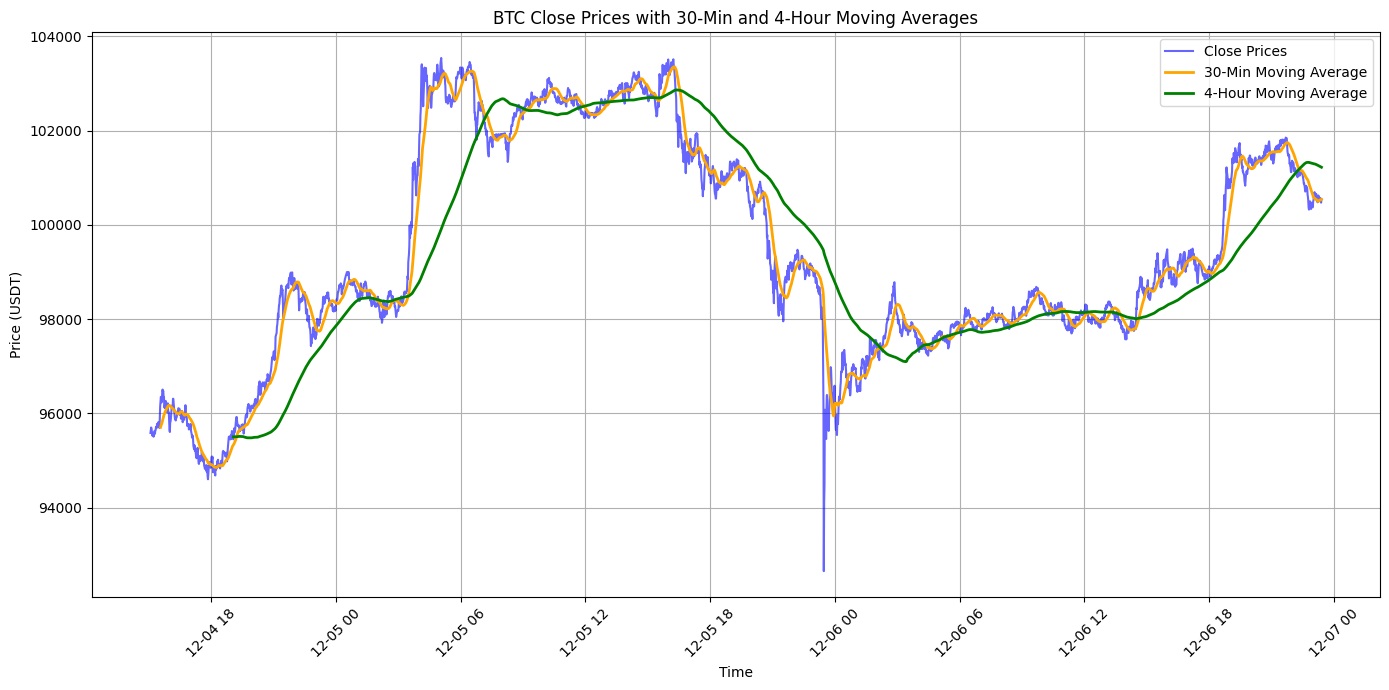

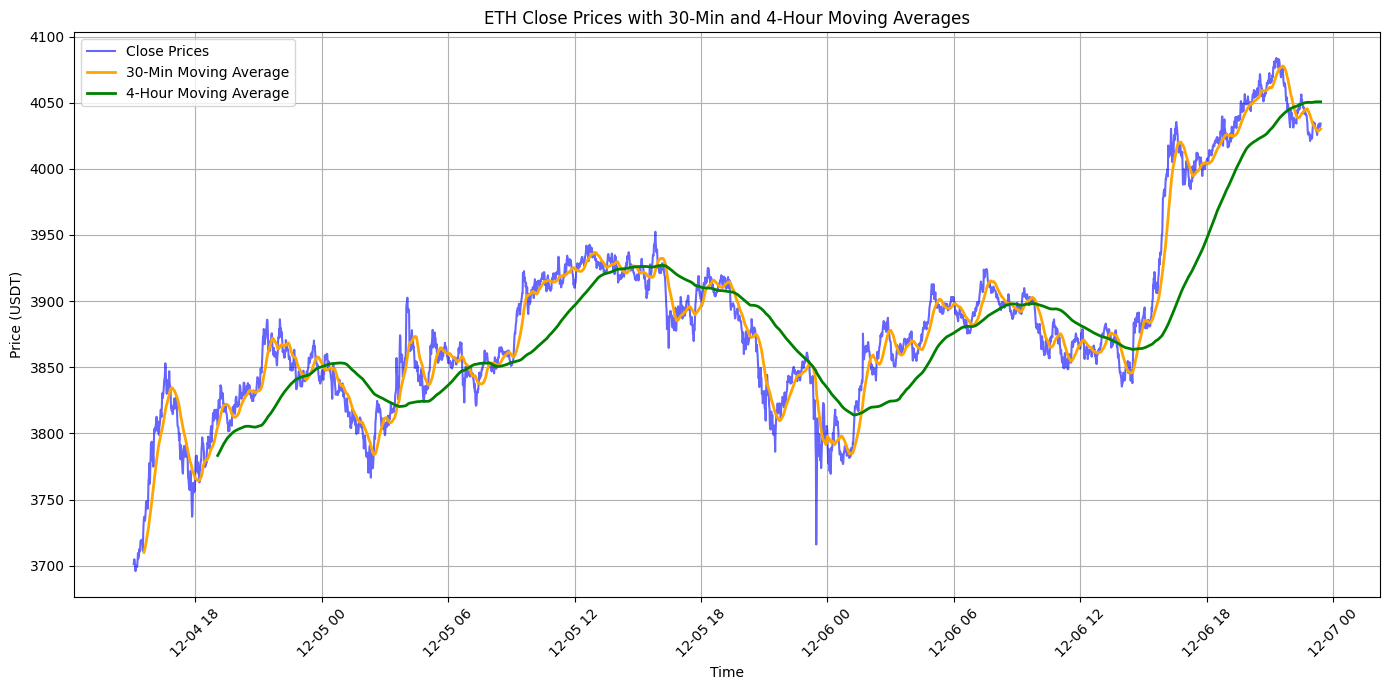

In [ ]:
# Task 3.1 Data Analysis - Price Trends: Compute and plot spot prices along with 4h and 30min moving averages.☑️
# I will take the close prices to calculate the respective moving averages.
# I will use both Matteo's BTC and ETH Binance Datasets for this execise.
#---------------------------------------------------------------------------------------------------------------------------------
def calculate_moving_averages(data, time_column, close_column):
    # Ensure time column is in datetime format
    data[time_column] = pd.to_datetime(data[time_column])
    
    # Calculate 30-minute moving average (assuming data frequency allows for this)
    # Assuming 1-minute interval: 30 * 1 = 30 data points
    data['MA_30min'] = data[close_column].rolling(window=30).mean()
    
    # Calculate 4-hour moving average (assuming 1-minute interval: 4 * 60 = 240 data points)
    data['MA_4h'] = data[close_column].rolling(window=240).mean()
    
    return data



def plot_moving_averages_with_time(data, title, time_col, close_col, ma_30_col, ma_4h_col):
    plt.figure(figsize=(14, 7))
    plt.plot(data[time_col], data[close_col], label='Close Prices', alpha=0.6, color='blue')
    plt.plot(data[time_col], data[ma_30_col], label='30-Min Moving Average', linewidth=2, color='orange')
    plt.plot(data[time_col], data[ma_4h_col], label='4-Hour Moving Average', linewidth=2, color='green')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price (USDT)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

#---------------------------------------------------------------------------------------------------------------------------------

# Load datasets
btc_data = pd.read_csv('Cleaned Datasets/BINANCE_BTCUSDT_CLEANED.csv')
eth_data = pd.read_csv('Cleaned Datasets/BINANCE_ETHUSDT_CLEANED.csv')

# Apply moving average calculation
btc_data = calculate_moving_averages(btc_data, 'time', 'close')
eth_data = calculate_moving_averages(eth_data, 'time', 'close')


# Plot for BTC
plot_moving_averages_with_time(
    btc_data, 
    'BTC Close Prices with 30-Min and 4-Hour Moving Averages', 
    time_col='time', 
    close_col='close', 
    ma_30_col='MA_30min', 
    ma_4h_col='MA_4h'
)

# Plot for ETH
plot_moving_averages_with_time(
    eth_data, 
    'ETH Close Prices with 30-Min and 4-Hour Moving Averages', 
    time_col='time', 
    close_col='close', 
    ma_30_col='MA_30min', 
    ma_4h_col='MA_4h'
)



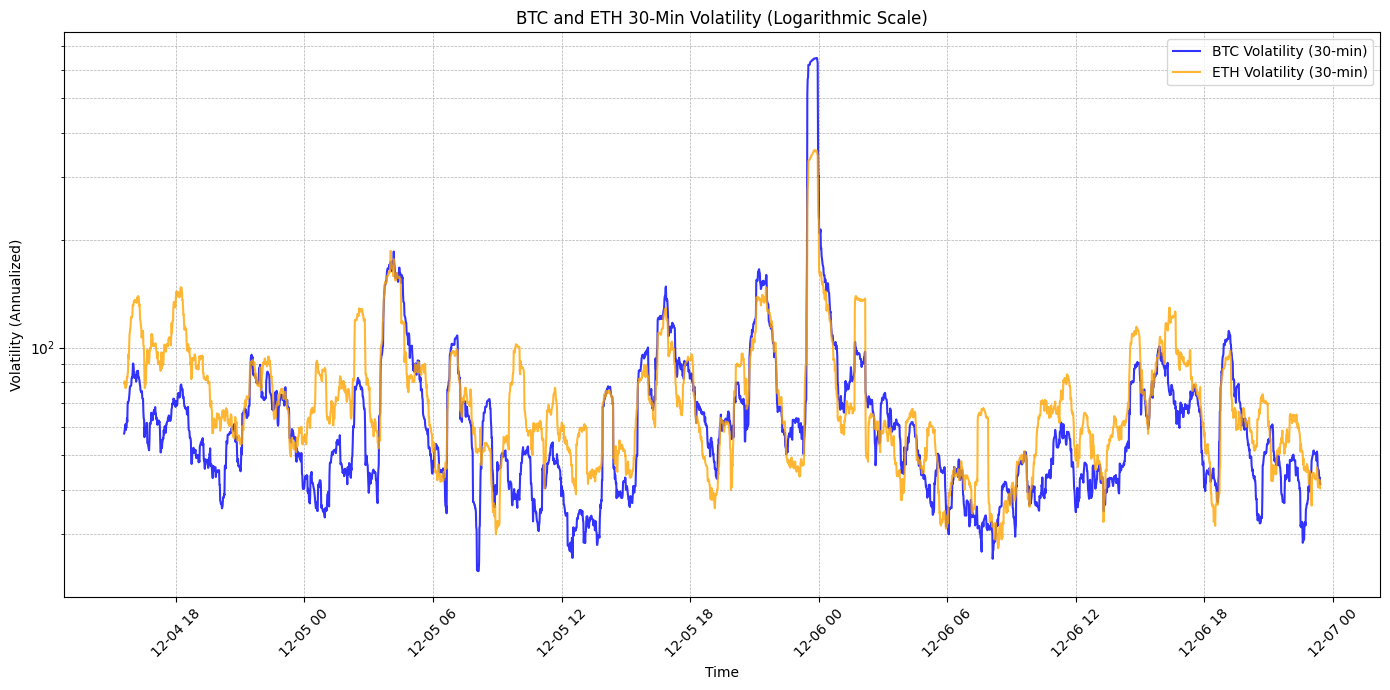

In [8]:
# Task 3.2 Data Analysis - Calculate rolling (annualized) volatility using a 30-minute window.☑️

def calculate_volatility(data, close_col, window, new_col_name):
    
    # Calculate log returns in %
    data['log_returns_%'] = (np.log(data[close_col] / data[close_col].shift(1)))*100
    
    # Calculate rolling standard deviation of log returns
    data[new_col_name] = data['log_returns_%'].rolling(window=window).std() * ((365*24*60)**0.5)  # Annualized volatility
    
    return data

#---------------------------------------------------------------------------------------------------------------------------------

# Calculate 30-minute volatility for BTC
btc_data = calculate_volatility(btc_data, close_col='close', window=30, new_col_name='Volatility_30min')

# Calculate 30-minute volatility for ETH
eth_data = calculate_volatility(eth_data, close_col='close', window=30, new_col_name='Volatility_30min')

# Save updated datasets

btc_data.to_csv('Calculated Datasets/BTC_BINANCE.csv', index=False)
eth_data.to_csv('Calculated Datasets/ETH_BINANCE.csv', index=False)

#---------------------------------------------------------------------------------------------------------------------------------

# Plot BTC and ETH volatilities in a single figure with gridlines for all ticks
plt.figure(figsize=(14, 7))

# Plot BTC volatility
plt.plot(btc_data['time'], btc_data['Volatility_30min'], label='BTC Volatility (30-min)', alpha=0.8, color='blue')

# Plot ETH volatility
plt.plot(eth_data['time'], eth_data['Volatility_30min'], label='ETH Volatility (30-min)', alpha=0.8, color='orange')

# Customize plot
plt.title('BTC and ETH 30-Min Volatility (Logarithmic Scale)')
plt.xlabel('Time')
plt.ylabel('Volatility (Annualized)')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()

# Add gridlines for both x and y axes
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()





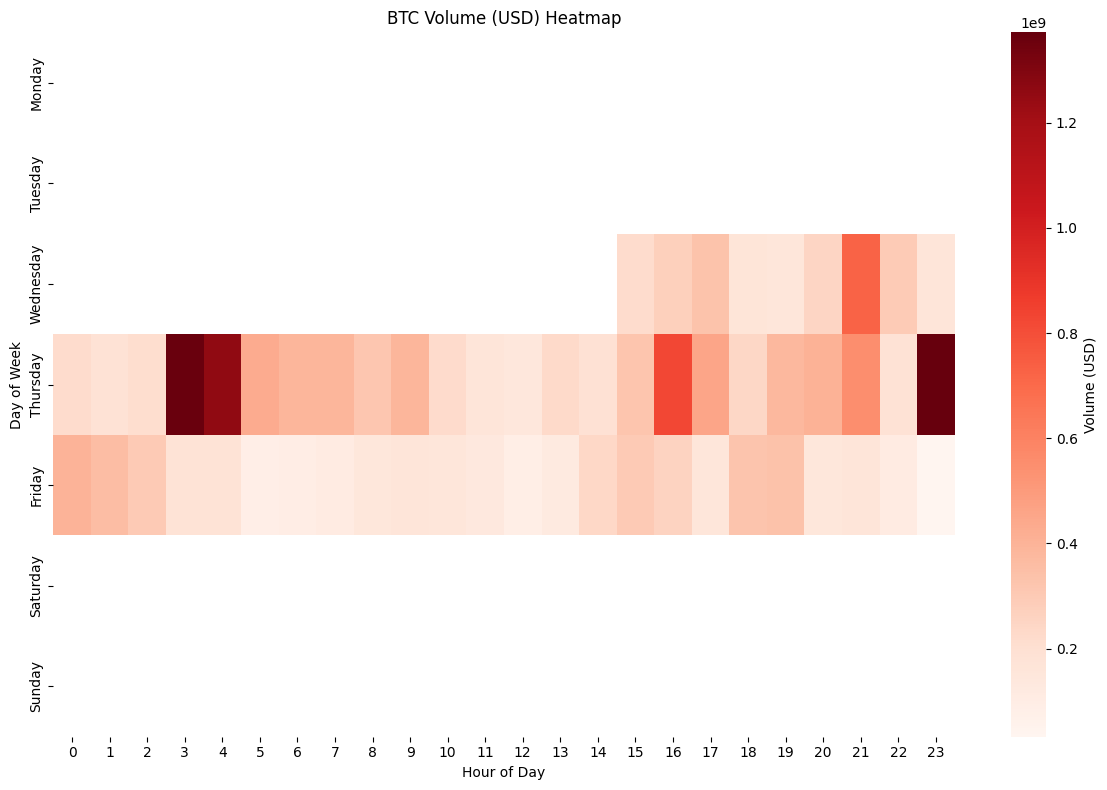

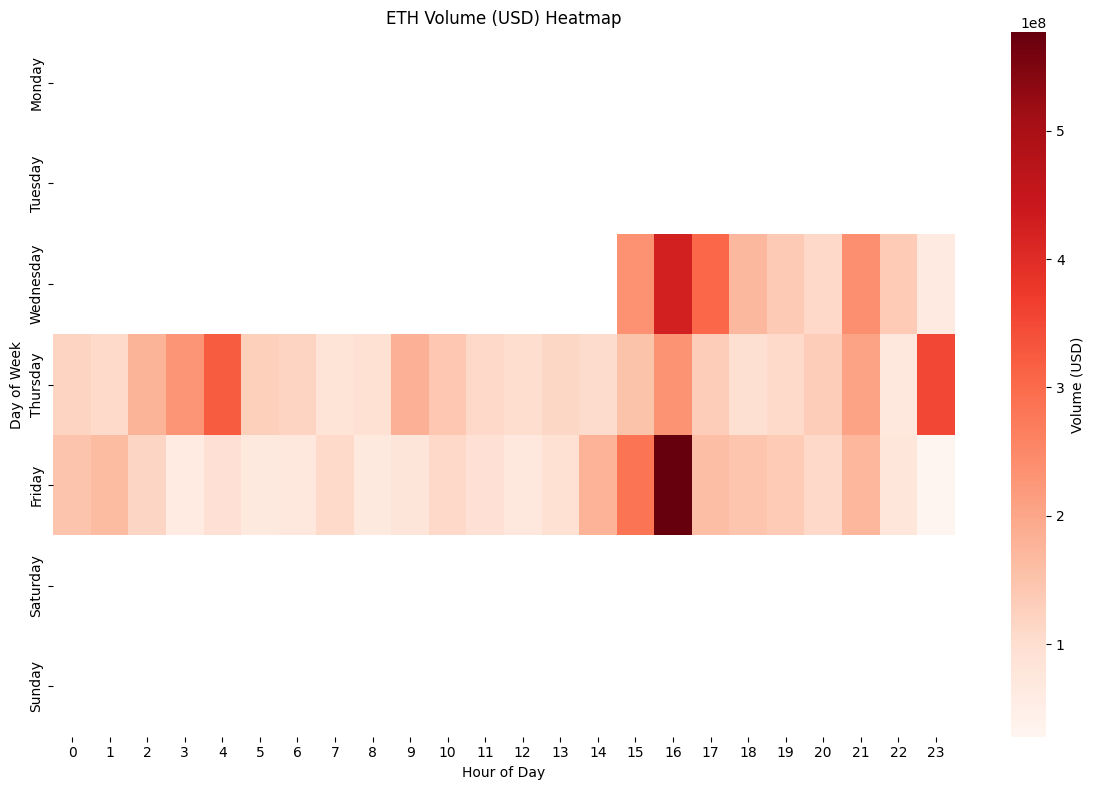

In [21]:
# Task 3.3 Data Analysis - Volume Analysis ☑️
# Attention: you need to run Task 3.1 first in order to run this task.
# First I want to calculate the volume in USD values:

#---------------------------------------------------------------------------------------------------------------------------------

# Add a new column for volume in USD (Volume * Close Price)
btc_data['Volume_USD'] = btc_data['Volume'] * btc_data['close']
eth_data['Volume_USD'] = eth_data['Volume'] * eth_data['close']

# Save the updated datasets
#btc_data.to_csv('Calculated Datasets/BTC_BINANCE.csv', index=False)
#eth_data.to_csv('Calculated Datasets/ETH_BINANCE.csv', index=False)

# Display the first few rows of the updated datasets for verification
# print("BTC Dataset with Volume in USD:")
# print(btc_data[['time', 'Volume', 'close', 'Volume_USD']].head())

# print("\nETH Dataset with Volume in USD:")
# print(eth_data[['time', 'Volume', 'close', 'Volume_USD']].head())

#---------------------------------------------------------------------------------------------------------------------------------
# Create heat-map of volume:

def create_volume_usd_heatmap(data, time_col, volume_usd_col, title):
    # Ensure time column is in datetime format
    data[time_col] = pd.to_datetime(data[time_col])

    # Extract hour and day of the week
    data['hour'] = data[time_col].dt.hour
    data['day_of_week'] = data[time_col].dt.day_name()

    # Aggregate Volume_USD by hour and day of the week
    volume_usd_pivot = data.pivot_table(
        values=volume_usd_col, 
        index='day_of_week', 
        columns='hour', 
        aggfunc='sum'
    )

    # Reorder days of the week
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    volume_usd_pivot = volume_usd_pivot.reindex(days_order)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(volume_usd_pivot, cmap="Reds", annot=False, cbar_kws={'label': 'Volume (USD)'})
    plt.title(title)
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.tight_layout()
    plt.show()

# Create heatmap for BTC Volume USD
create_volume_usd_heatmap(btc_data, time_col='time', volume_usd_col='Volume_USD', title='BTC Volume (USD) Heatmap')

# Create heatmap for ETH Volume USD
create_volume_usd_heatmap(eth_data, time_col='time', volume_usd_col='Volume_USD', title='ETH Volume (USD) Heatmap')


In [12]:
# Task 3.4 Data Analysis - Correlation between BTC and ETH ☑️

# Merge BTC and ETH datasets on the time column for correlation analysis
btc_eth_merged = pd.merge(
    btc_data[['time', 'close']], 
    eth_data[['time', 'close']], 
    on='time', 
    suffixes=('_BTC', '_ETH')
)

# Calculate the correlation between BTC and ETH close prices
correlation = btc_eth_merged['close_BTC'].corr(btc_eth_merged['close_ETH'])

# Print the correlation
print(f"Correlation between BTC and ETH close prices: {correlation}")


Correlation between BTC and ETH close prices: 0.5155856769613929


In [13]:
# Task 3.5 Data Analysis - Cointegration between BTC and ETH ☑️
# Run Task 3.4 first before running 3.5

# Merge BTC and ETH datasets on the time column
# btc_eth_merged = pd.merge(
#     btc_data[['time', 'close']], 
#     eth_data[['time', 'close']], 
#     on='time', 
#     suffixes=('_BTC', '_ETH')
# )

# Extract the close prices
btc_close = btc_eth_merged['close_BTC']
eth_close = btc_eth_merged['close_ETH']

# Perform the Engle-Granger cointegration test
coint_result = coint(btc_close, eth_close)

# Extract test statistic, p-value, and critical values
test_statistic = coint_result[0]
p_value = coint_result[1]
critical_values = coint_result[2]

# Print the results
print("Engle-Granger Cointegration Test Results:")
print(f"Test Statistic: {test_statistic}")
print(f"P-Value: {p_value}")
print(f"Critical Values: {critical_values}")


Engle-Granger Cointegration Test Results:
Test Statistic: -1.3920591422813138
P-Value: 0.8002221892386033
Critical Values: [-3.8996841  -3.33793885 -3.0457054 ]


In [14]:
# 4.1 Visualizations - Line chart with moving averages - done in 3.1 ☑️

In [23]:
# 4.2 Visualizations - Heatmap of trading volumes - done in 3.3 ☑️

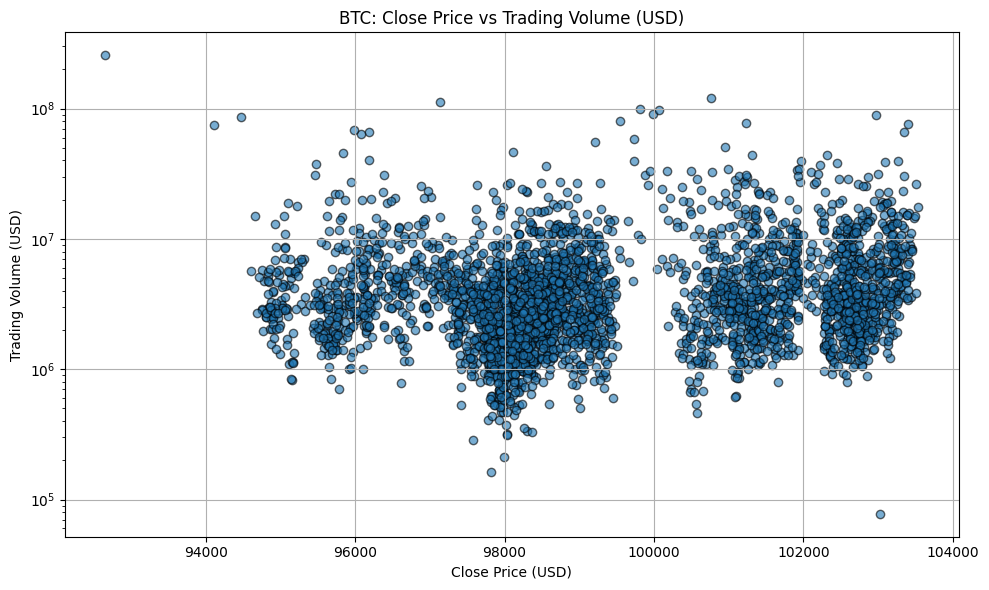

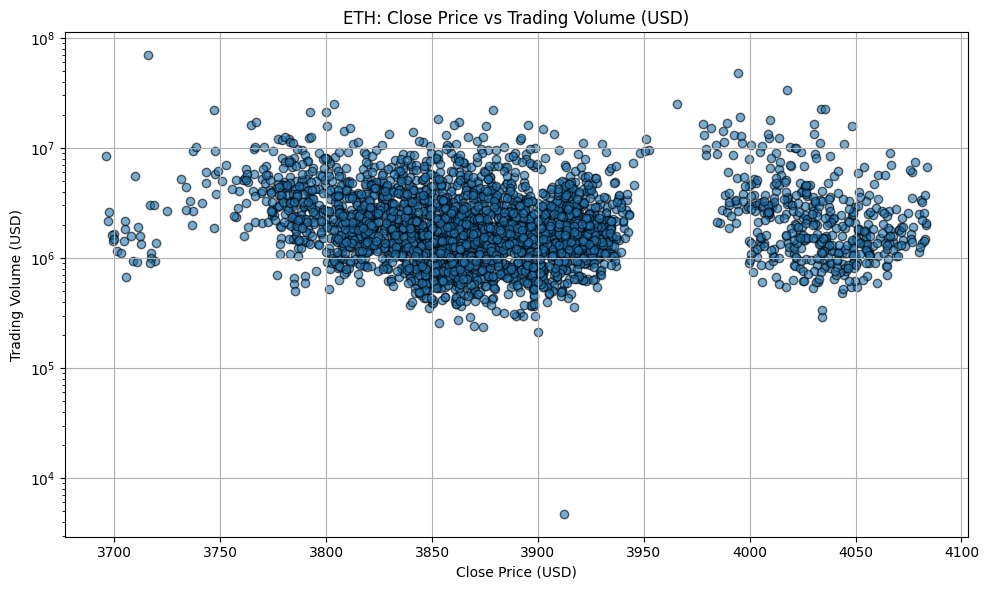

In [24]:
# 4.3 Visualizations - Scatter plot illustrating relationship between price and volume ☑️
# Function to create scatter plot
def plot_close_vs_volume(data, close_col, volume_usd_col, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[close_col], data[volume_usd_col], alpha=0.6, edgecolor='k')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Close Price (USD)')
    plt.ylabel('Trading Volume (USD)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Scatter plot for BTC
plot_close_vs_volume(
    btc_data, 
    close_col='close', 
    volume_usd_col='Volume_USD', 
    title='BTC: Close Price vs Trading Volume (USD)'
)

# Scatter plot for ETH
plot_close_vs_volume(
    eth_data, 
    close_col='close', 
    volume_usd_col='Volume_USD', 
    title='ETH: Close Price vs Trading Volume (USD)'
)